In [1]:
DATASET_DIR = "C:\\Repos\\Datasets\\multiview_hand_pose_dataset_uploaded_v2"

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
import os

In [3]:
# read in first image
img = plt.imread(DATASET_DIR + "\\annotated_frames\\data_1\\0_webcam_2.jpg")

# read in the joint locations
joints = pd.read_csv(DATASET_DIR + "\\projections_2d\\data_1\\0_jointsCam_2.txt", sep=" ", header=None)
joints.columns = ['Joint', 'X', 'Y']
joints.head()

,Joint,X,Y
0,F4_KNU1_A,378.597863,204.892570
1,F4_KNU1_B,333.350064,217.852999
2,F4_KNU2_A,405.124629,202.240105
3,F4_KNU3_A,422.801732,203.467708
4,F3_KNU1_A,384.884037,227.395152


In [4]:
from SQLTools import *
import sqlite3

In [5]:
database = Fetch_Database("./Database/joint_data.db")

In [29]:
# create cursor
c = database.cursor()

# get size of database
c.execute("SELECT COUNT(*) FROM data;")
size = c.fetchone()[0]

# pull a random image from the database
image_id = np.random.randint(0, size)

c.execute("SELECT img, label, bbox FROM data WHERE id = ?", (image_id,))
image, label, bbox = c.fetchone()
bbox = bbox[:, 0]

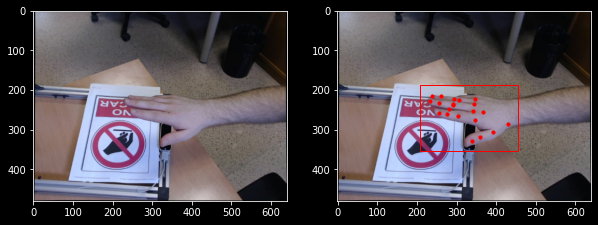

In [35]:
# display the image and its bounding box and joint locations
# bbox is in for [top, left, bottom, right]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[1].imshow(image)

bbox_rect = patches.Rectangle((image.shape[0] * bbox[1], image.shape[1] * bbox[0]), image.shape[0] * bbox[2], image.shape[1] * bbox[3], linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(bbox_rect)

# joint labels are between 0 and 1, so we need to scale them to the image size
ax[1].scatter(label[:, 0] * image.shape[1], label[:, 1] * image.shape[0], s=10, c='r')


In [8]:
dataset = Extract_TF_Dataset("./Database/joint_data_lite.db", label_name="bbox")

In [9]:
dataset = dataset.map(lambda img, label: (img, tf.squeeze(label)))
print(dataset.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>


In [10]:
# Now we want to use a pretrained, lightweight model to transfer learn off of.
# The goal is to find the bounding box from a low-res image, and then use it to crop
# the high-res image.

In [11]:
# # iterate through the rows of the database, pulling out the image and bbox. The image needs to be scaled to 224x224
# # all the images should be added to a tf dataset

# images = np.zeros((size, 224, 224, 3))
# bboxes = np.zeros((size, 4))
# for i in tqdm.tqdm(range(size)):
#     c.execute("SELECT img, bbox FROM data WHERE id = ?", (i+1,))
#     image, bbox = c.fetchone()

#     # save the original image shape
#     original_shape = image.shape

#     # scale the image to 224x224
#     image = tf.image.resize(image, [224, 224])

#     # convert the image to between 0 and 1
#     # image = tf.cast(image, tf.float32) / 255.0

#     # convert the bboxes to between 0 and 1, and rescale them to match the resized image
#     # determine the rescaling factor for both the x and y axis
#     x_scale = 224.0 / original_shape[1]
#     y_scale = 224.0 / original_shape[0]
#     # scale bboxes to 0-1
#     bbox = np.array([bbox[0] / original_shape[0], bbox[1] / original_shape[1], bbox[2] / original_shape[0], bbox[3] / original_shape[1]])
#     # bbox = bbox * [x_scale, y_scale, x_scale, y_scale]

#     # add the image to the dataset
#     images[i] = image
#     # add the bbox to the dataset
#     bboxes[i] = bbox[:,0]


In [12]:
# import mobilenet v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [13]:
# create a custom loss function
# the goal is to minimize the difference between the predicted bbox and the actual bbox
# but also to ensure the predicted bbox is not smaller than the actual bbox
def custom_loss(y_true, y_pred, lamda=0.5):
    # mse
    diff = tf.math.abs(y_true - y_pred)
    squ = tf.math.square(diff)
    mse = tf.math.reduce_mean(squ)

    # ensure the predicted bbox is not smaller than the actual bbox
    # calculate the area of the predicted bbox
    pred_area = (y_pred[3] - y_pred[1]) * (y_pred[2] - y_pred[0])
    # calculate the area of the actual bbox
    actual_area = (y_true[3] - y_true[1]) * (y_true[2] - y_true[0])
    # calculate the difference of the predicted bbox to the actual bbox
    # if the predicted bbox is larger, the reation will be negative, rewarding the model
    ratio = actual_area - pred_area
    # pass the ratio through tanh to ensure it is between -1 and 1
    ratio = tf.math.tanh(ratio)

    # calculate the loss
    return lamda * mse + (1 - lamda) * ratio

In [14]:
# setup preprocessing
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
preprocess_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)

# load the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=preprocess_layer)

# freeze the model
base_model.trainable = False

# add a dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# add a dense layer with 4 outputs. They will be the top-left, top-right, bottom-left, bottom-right
# corner of the bounding box. They should be sigmoided to be between 0 and 1
predictions = tf.keras.layers.Dense(4, activation='sigmoid')(x)

# compile the model
model = tf.keras.models.Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# print out the model summary
# model.summary()

In [15]:
# create a checkpoint callback
checkpoint_path = "./checkpoints/typeb_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

# load the checkpoint if it exists
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

In [16]:
# prep the train and validation datasets
dataset = dataset.shuffle(buffer_size=1000)
train_dataset = dataset.take(1000).batch(32)
val_dataset = dataset.skip(1000).batch(32)

In [17]:
# train the model
H = model.fit(train_dataset, validation_data=val_dataset, epochs=10, batch_size=32, callbacks=[cp_callback])

Epoch 1/10
32/32 [==============================] - 23s 372ms/step - loss: 0.0100 - accuracy: 0.4400 - val_loss: 0.0081 - val_accuracy: 0.1861
Epoch 2/10
32/32 [==============================] - 8s 258ms/step - loss: 0.0073 - accuracy: 0.2980 - val_loss: 0.0074 - val_accuracy: 0.0748
Epoch 3/10
32/32 [==============================] - 8s 256ms/step - loss: 0.0074 - accuracy: 0.2170 - val_loss: 0.0077 - val_accuracy: 0.1889
Epoch 4/10
32/32 [==============================] - 8s 260ms/step - loss: 0.0076 - accuracy: 0.2100 - val_loss: 0.0071 - val_accuracy: 0.1921
Epoch 5/10
32/32 [==============================] - 9s 279ms/step - loss: 0.0070 - accuracy: 0.2130 - val_loss: 0.0072 - val_accuracy: 0.1801
Epoch 6/10
32/32 [==============================] - 9s 280ms/step - loss: 0.0071 - accuracy: 0.2050 - val_loss: 0.0071 - val_accuracy: 0.1894
Epoch 7/10
32/32 [==============================] - 8s 269ms/step - loss: 0.0066 - accuracy: 0.2120 - val_loss: 0.0063 - val_accuracy: 0.1796
Epoch

Text(0.5, 1.0, 'Training Accuracy')

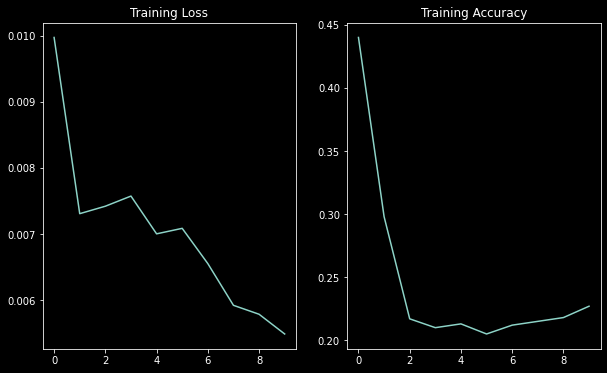

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# plot the training history scaled on the left axis
ax[0].plot(H.history['loss'], label='loss')
# plot accuracy on the right axis
ax[1].plot(H.history['accuracy'], label='accuracy')
ax[0].set_title('Training Loss')
ax[1].set_title('Training Accuracy')

Text(0.5, 1.0, 'Predicted Bounding Box')

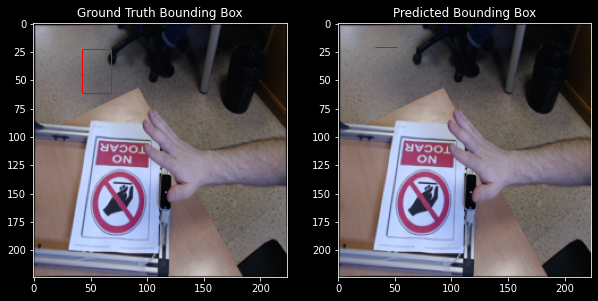

In [36]:
# display some predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# fetch a random image from the validation dataset
image, ground_truth = next(iter(dataset))

# predict the bounding box
bbox = model.predict(image[np.newaxis, :, :, :])

# scale the bbox to the image size
bbox = bbox * [image.shape[1], image.shape[0], image.shape[1], image.shape[0]]
ground_truth = ground_truth * [image.shape[0], image.shape[1], image.shape[0], image.shape[1]]

# display the image and the ground truth bounding box
ax[0].imshow(image)
gt_bbox_rect = patches.Rectangle((ground_truth[1], ground_truth[0]), ground_truth[3], ground_truth[2], linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(gt_bbox_rect)
ax[0].set_title('Ground Truth Bounding Box')

# display the image and the predicted bounding box
ax[1].imshow(image)
bbox_rect = patches.Rectangle((bbox[0][1], bbox[0][0]), bbox[0][3], bbox[0][2], linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(bbox_rect)
ax[1].set_title('Predicted Bounding Box')